### Calibration Plots 

In this notebook we produce calibration plots for the (marginalized) posterior distributions that the BNN outputs.

In [42]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer
#!pip3 install pyimfit

Load python libraries

In [4]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse
import time

# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# PyImfit, ChainConsumer and Emcee
import pyimfit
from chainconsumer import ChainConsumer

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [5]:
# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [6]:
# Mount drive to upload/download the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Functions that convert surface brightness from counts/pixel to mag/arcsec^2 and the opposite**

In [7]:
# Converts from counts/pixel to mag/arcsec
def counts_to_SB(Counts):
  Area = (0.263)**2.0
  SB = -2.5*np.log10(Counts/Area)+30.
  return SB

# Converts from mag/arcsec to counts/pixel
def SB_to_counts(SB):
  Area = (0.263)**2.0
  exponent = (30.0-SB)/2.5
  Counts = Area*(10.0**exponent)
  return Counts

# Convert pixels to arcsec
def pix_to_asec(pix):
  asec = pix*0.263
  return asec

# Convert arcsec to pixels
def asec_to_pix(asec):
  pix = asec/0.263
  return pix

**Load Datasets**

In [8]:
# Images
X_test = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_test.npy"))
# Labels
y_train = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_train.npy"))
y_test = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_test.npy"))
#Scaling
scale_test = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/scale_test.npy"))

**Scale the Labels**

In [9]:
scaler = StandardScaler()
# Rescale the labels
scaler.fit(y_train)
y_train_sc = scaler.transform(y_train)
y_test_sc = scaler.transform(y_test)

### Define the BNN model

In [10]:
# Define basic numbers
IMAGE_SHAPE = [64, 64, 1]
NUM_TRAIN_EXAMPLES = 150000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 10000
NUM_CLASSES = 5

In [11]:
# Define KL function

tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

Define BNN architecture and load the model weights

In [12]:
# Bayesian DeepBFit in functional form
model_input = Input(shape=(64,64,1))
# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(model_input)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 2nd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 8, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 3rd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 16, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 4th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 32, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 5th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 64, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)                    
# =========================================
# =========================================
x = keras.layers.Flatten()(x)
# =========================================
# =========================================
x = tfp.layers.DenseFlipout(
          units = 1024,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(5))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=5)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [13]:
model.load_weights('/content/drive/My Drive/BNN_Final_Codes/BNN_weights.h5')

### Make predictions on a part of the test set


Keep 1000 examples

In [14]:
n_test = 1000

X_keep = X_test[:n_test]
y_keep = y_test[:n_test]
y_keep_sc = y_test_sc[:n_test]
scale_keep = scale_test[:n_test]

print(np.shape(X_keep))

(1000, 64, 64, 1)


In [15]:
pred_dist = model(X_keep)
sample = np.asarray(pred_dist.sample(300))

print(np.shape(sample))

n_rands = 400

#Time it
tim_in = time.time()

for i in range(n_rands):
  pred_dist = model(X_keep)
  sample_loc = np.asarray(pred_dist.sample(300))
  sample = np.concatenate((sample,sample_loc))


tim_fin = time.time()
print("Time for the BNN predictions to run (in minutes):")
print((tim_fin-tim_in)/60.0)

(300, 1000, 5)
Time for the BNN predictions to run (in minutes):
7.344662050406138


Let's make a corner plot for a single image of a galaxy.

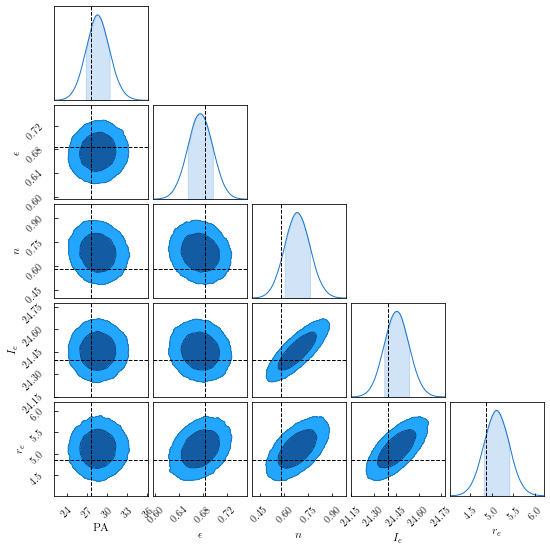

In [16]:
sample_new_single = scaler.inverse_transform(np.asarray(sample[:,130,:]))

c = ChainConsumer()
c.add_chain(sample_new_single,parameters=["PA", "$\epsilon$", "$n$", "$I_e$", "$r_e$"])
fig = c.plotter.plot(figsize=(8,8), truth=y_keep[130])

Invert the sample to get true parameters

In [17]:
# Invert the sample, to get true parameters

inv_sample = []

for i in range(n_test):
  inv_sample_loc = scaler.inverse_transform(sample[:,i,:])
  inv_sample.append(inv_sample_loc)

### Get means, medians, and standard deviations


In [18]:
# Get means
mean_preds = np.mean(inv_sample,axis=1)
# Get medians
median_preds = np.median(inv_sample,axis=1)
# Get standard deviations
std_preds = np.std(inv_sample,axis=1)

Order of predictions: PA, ellipticity, $n$ (sersic index), $I_e$ (mean surface brightness at effective radius), $r_e$ (effective radius).

### Make calibration plots

In [19]:
# Import resampling, we will need it for bootstap resampling
from sklearn.utils import resample #Resampling

Samples and true values of the parameters

In [20]:
# Effective radius 
sample_r_eff = np.asarray(inv_sample)[:,:,-1]
r_eff_true = y_keep[:,-1]
# Mean Surface brightness
sample_I_eff = np.asarray(inv_sample)[:,:,-2]
I_eff_true = y_keep[:,-2]
# Sersic Index
sample_n = np.asarray(inv_sample)[:,:,-3]
n_true = y_keep[:,-3]
# Ellipticity
sample_ell = np.asarray(inv_sample)[:,:,-4]
ell_true = y_keep[:,-4]
# Position Angle
sample_PA = np.asarray(inv_sample)[:,:,-5]
PA_true = y_keep[:,-5]

### Calibration Plot

Create function(s) that create calibration plots for each one of the parameters 

In [21]:
# Define percents and percentiles
percentiles = np.linspace(0,1,40)

# Percents 
percents = np.zeros(20)
for i in range(20):
  percents[i] = percentiles[39-i]-percentiles[i]

# Write function that returns limits of percentiles 
# for specific parameter
def lims_perc(sample_param):
  sample_shift = sample_param
  lims = np.quantile(sample_shift,percentiles, axis=1) 
  return lims

In [22]:
# Get limits for the five parameters
lims_reff = lims_perc(sample_r_eff)
lims_I_eff = lims_perc(sample_I_eff)
lims_n = lims_perc(sample_n)
lims_ell = lims_perc(sample_ell)
lims_PA = lims_perc(sample_PA)

Write a function that calculates the fraction of galaxies within the percentiles. 

In [23]:
def fraction_param(lims_par,par_true):
  nums = np.zeros(20)
  
  for i in range(20):
    nums_i = 0
    for j in range(n_test):
      u_lim = lims_par[39-i,j]
      l_lim = lims_par[i,j]
      true_par_j = par_true[j]

      if ((true_par_j>=l_lim)&(true_par_j<=u_lim)):
        nums_i +=1

      nums[i] = nums_i
      fraction = nums/1000
  return fraction

Calculate the fractions

In [24]:
fraction_reff = fraction_param(lims_reff,r_eff_true)
fraction_I_eff = fraction_param(lims_I_eff,I_eff_true)
fraction_n = fraction_param(lims_n,n_true)
fraction_ell = fraction_param(lims_ell,ell_true)
fraction_PA = fraction_param(lims_PA,PA_true)

### Calculate confidence intervals using bootstrap resampling

In [34]:
def bootstrap_error(sample_par,par_true):
  # Computes upper and lower bound using bootstrap resampling

  n_bootstrap = 100
  indices = np.arange(1000)
  nums_boot = np.zeros((100,20))

  for i in range(n_bootstrap):
    if (i%10==0):
      print(i)

    # Resample
    ind_loc = resample(indices, n_samples=len(indices), replace=True)
    # Create new sample
    param_true_local = par_true[ind_loc]
    sample_shift_loc = sample_par[ind_loc]
    lims_loc = np.quantile(sample_shift_loc,percentiles, axis=1)

    for j in range(20):
      nums_j = 0 
      for k in range(n_test):
        u_lim = lims_loc[39-j,k]
        l_lim = lims_loc[j,k]
        true_par_k = param_true_local[k]

        if ((true_par_k>=l_lim)&(true_par_k<=u_lim)):
          nums_j +=1

        nums_boot[i,j] = nums_j/1000.

  # Compute the lower and upper bound of the 95% confidence interval
  lower = np.quantile(nums_boot,0.025, axis=0)
  upper = np.quantile(nums_boot,0.975, axis=0)

  return lower, upper

### Calculate upper and lower limits and make plots

- Effective radius

In [35]:
# Effective radius
low_reff, upp_reff = bootstrap_error(sample_r_eff,r_eff_true)

0
10
20
30
40
50
60
70
80
90


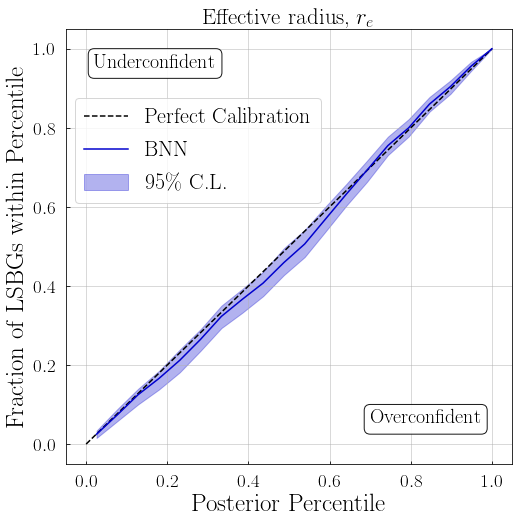

In [38]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)


x = np.linspace(0,1,100)
plt.figure(figsize=(8., 8.))

# Plot title
plt.title('Effective radius, $r_e$', fontsize=23)


plt.plot(x,x,ls='--',c='k',label='Perfect Calibration')
plt.plot(percents,fraction_reff,c='mediumblue',label='BNN')
plt.fill_between(percents,low_reff,upp_reff,color='mediumblue',
                 rasterized=True,alpha=0.3,label='95$\%$ C.L.')


plt.grid(alpha=0.6)

plt.xlabel('Posterior Percentile', fontsize=25)
plt.ylabel('Fraction of LSBGs within Percentile', fontsize=25)

# Text
plt.text(0.7,0.05,'Overconfident', bbox=props, fontsize=20)
plt.text(0.02,0.95,'Underconfident', bbox=props,fontsize=20)

#Configure plot
plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc=(0.02,0.6),ncol=1, fontsize=22)
#Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Calibration_Plot_reff.pdf",bbox_inches='tight')
plt.show()

- Surface brightness 

In [39]:
# Effective radius
low_I_eff, upp_I_eff = bootstrap_error(sample_I_eff,I_eff_true)

0
10
20
30
40
50
60
70
80
90


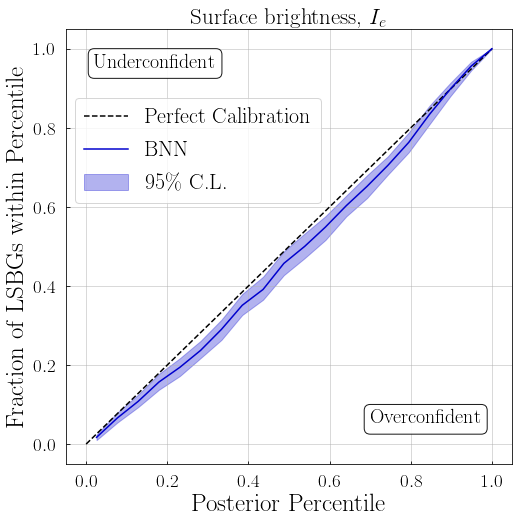

In [40]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)


x = np.linspace(0,1,100)
plt.figure(figsize=(8., 8.))

# Plot title
plt.title('Surface brightness, $I_e$', fontsize=23)


plt.plot(x,x,ls='--',c='k',label='Perfect Calibration')
plt.plot(percents,fraction_I_eff,c='mediumblue',label='BNN')
plt.fill_between(percents,low_I_eff,upp_I_eff,color='mediumblue',
                 rasterized=True,alpha=0.3,label='95$\%$ C.L.')


plt.grid(alpha=0.6)

plt.xlabel('Posterior Percentile', fontsize=25)
plt.ylabel('Fraction of LSBGs within Percentile', fontsize=25)

# Text
plt.text(0.7,0.05,'Overconfident', bbox=props, fontsize=20)
plt.text(0.02,0.95,'Underconfident', bbox=props,fontsize=20)

#Configure plot
plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc=(0.02,0.6),ncol=1, fontsize=22)
#Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Calibration_Plot_I_eff.pdf",bbox_inches='tight')
plt.show()

- Sersic Index

In [41]:
# For sersic index
low_n, upp_n = bootstrap_error(sample_n,n_true)

0
10
20
30
40
50
60
70
80
90


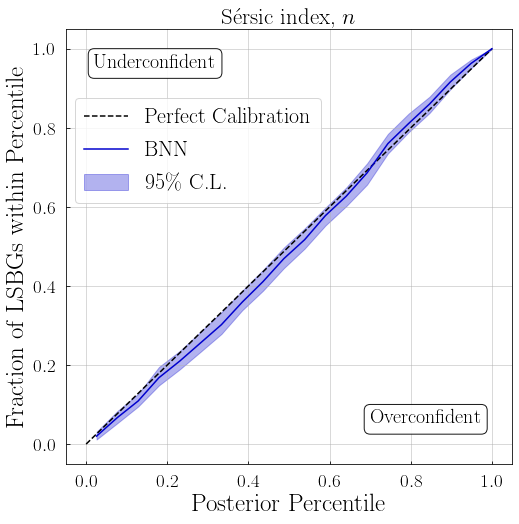

In [49]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)


x = np.linspace(0,1,100)
plt.figure(figsize=(8., 8.))

# Plot title
plt.title('Sérsic index, $n$', fontsize=23)


plt.plot(x,x,ls='--',c='k',label='Perfect Calibration')
plt.plot(percents,fraction_n,c='mediumblue',label='BNN')
plt.fill_between(percents,low_n,upp_n,color='mediumblue',
                 rasterized=True,alpha=0.3,label='95$\%$ C.L.')


plt.grid(alpha=0.6)

plt.xlabel('Posterior Percentile', fontsize=25)
plt.ylabel('Fraction of LSBGs within Percentile', fontsize=25)

# Text
plt.text(0.7,0.05,'Overconfident', bbox=props, fontsize=20)
plt.text(0.02,0.95,'Underconfident', bbox=props,fontsize=20)

#Configure plot
plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc=(0.02,0.6),ncol=1, fontsize=22)
#Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Calibration_Plot_n.pdf",bbox_inches='tight')
plt.show()

- For ellipticity

In [44]:
# For ellipticity
low_ell, upp_ell = bootstrap_error(sample_ell,ell_true)

0
10
20
30
40
50
60
70
80
90


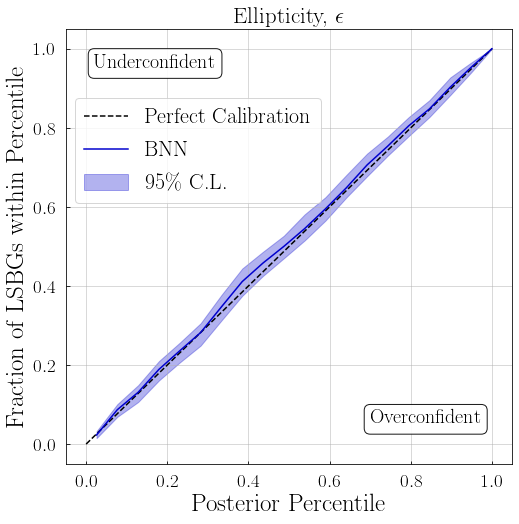

In [46]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)


x = np.linspace(0,1,100)
plt.figure(figsize=(8., 8.))

# Plot title
plt.title('Ellipticity, $\epsilon$', fontsize=23)


plt.plot(x,x,ls='--',c='k',label='Perfect Calibration')
plt.plot(percents,fraction_ell,c='mediumblue',label='BNN')
plt.fill_between(percents,low_ell,upp_ell,color='mediumblue',
                 rasterized=True,alpha=0.3,label='95$\%$ C.L.')


plt.grid(alpha=0.6)

plt.xlabel('Posterior Percentile', fontsize=25)
plt.ylabel('Fraction of LSBGs within Percentile', fontsize=25)

# Text
plt.text(0.7,0.05,'Overconfident', bbox=props, fontsize=20)
plt.text(0.02,0.95,'Underconfident', bbox=props,fontsize=20)

#Configure plot
plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc=(0.02,0.6),ncol=1, fontsize=22)
#Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Calibration_Plot_ell.pdf",bbox_inches='tight')
plt.show()

- For Position Angle

In [47]:
# For Position Angle
low_PA, upp_PA = bootstrap_error(sample_PA,PA_true)

0
10
20
30
40
50
60
70
80
90


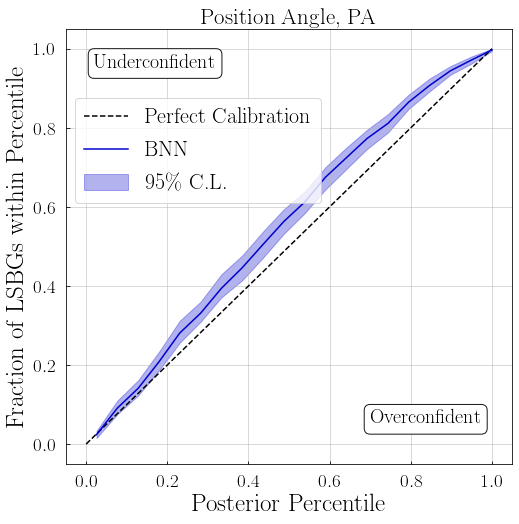

In [48]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)


x = np.linspace(0,1,100)
plt.figure(figsize=(8., 8.))

# Plot title
plt.title('Position Angle, PA', fontsize=23)


plt.plot(x,x,ls='--',c='k',label='Perfect Calibration')
plt.plot(percents,fraction_PA,c='mediumblue',label='BNN')
plt.fill_between(percents,low_PA,upp_PA,color='mediumblue',
                 rasterized=True,alpha=0.3,label='95$\%$ C.L.')


plt.grid(alpha=0.6)

plt.xlabel('Posterior Percentile', fontsize=25)
plt.ylabel('Fraction of LSBGs within Percentile', fontsize=25)

# Text
plt.text(0.7,0.05,'Overconfident', bbox=props, fontsize=20)
plt.text(0.02,0.95,'Underconfident', bbox=props,fontsize=20)

#Configure plot
plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc=(0.02,0.6),ncol=1, fontsize=22)
#Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Calibration_Plot_PA.pdf",bbox_inches='tight')
plt.show()

### Scatter plots


- Get pyImfit predictions

In [50]:
def imfit_pars_errors(X_0,y_0):
  """
  Gets best-fit (maximum likelihood) estimates  
  """

  # Define the model for a single image
  # Initialize on the true parameters

  # CREATE AND FIT A PYIMFIT MODEL
  model_im = pyimfit.SimpleModelDescription()
  # define the X0,Y0 
  model_im.x0.setValue(32., fixed=True)
  model_im.y0.setValue(32., fixed=True)
  # create a FlatSky uniform background
  FlatSky_function = pyimfit.make_imfit_function("FlatSky")
  FlatSky_function.I_sky.setValue(SB_to_counts(22.23), fixed=True)
  # create a Sersic profile
  Sersic_function = pyimfit.make_imfit_function("Sersic")
  Sersic_function.PA.setValue(y_0[0])
  Sersic_function.ell.setValue(y_0[1])
  Sersic_function.n.setValue(y_0[2])
  Sersic_function.I_e.setValue(SB_to_counts(y_0[3]))
  Sersic_function.r_e.setValue(asec_to_pix(y_0[4]))

  model_im.addFunction(FlatSky_function)
  model_im.addFunction(Sersic_function)

  # Fit and get predictions
  imfit_fitter = pyimfit.Imfit(model_im)
  imfit_fitter.loadData(X_0.reshape(64,64))

  results = imfit_fitter.doFit(getSummary=True)
  p_bestfit = results.params
  err_bestfit = results.paramErrs

  return p_bestfit[3:], err_bestfit[3:]

In [51]:
best_fits = np.zeros((n_test,5))
err_fits = np.zeros((n_test,5))


for i in range(n_test):
  X_scaled_i = X_keep[i]*scale_keep[i]
  y_i = y_keep[i]

  best_fits_unscaled, err_fits_unscaled = imfit_pars_errors(X_scaled_i,y_i)

  best_fits_unscaled[3] = counts_to_SB(best_fits_unscaled[3])
  best_fits_unscaled[4] = pix_to_asec(best_fits_unscaled[4])

  err_fits_unscaled[3] = counts_to_SB(err_fits_unscaled[3])
  err_fits_unscaled[4] = pix_to_asec(err_fits_unscaled[4])

  best_fits[i] = best_fits_unscaled
  err_fits[i] = err_fits_unscaled

**Get predictions**

In [53]:
# Effective radius
r_eff_imf = best_fits[:,-1]
r_eff_true = y_keep[:,-1]
# Surface brightness
I_eff_imf = best_fits[:,-2]
I_eff_true = y_keep[:,-2]
# Sersic index
n_imf = best_fits[:,-3]
n_true = y_keep[:,-3]
# Ellipticity
ell_imf = best_fits[:,-4]
ell_true = y_keep[:,-4]
# Position angle 
PA_imf = best_fits[:,-5]
PA_true = y_keep[:,-5]

# ====================================
# ====================================
# BNN predictions
r_eff_pred = mean_preds[:,-1]
I_eff_pred = mean_preds[:,-2]
n_pred = mean_preds[:,-3]
ell_pred = mean_preds[:,-4]
PA_pred = mean_preds[:,-5]

In [54]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_eff_true, r_eff_pred)

R_square_BNN = np.copy(r_value)**2.0

print(R_square_BNN)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_eff_true, r_eff_imf)

R_square_imf = np.copy(r_value)**2.0

print(R_square_imf)

0.8293951723060484
0.5446226624527285


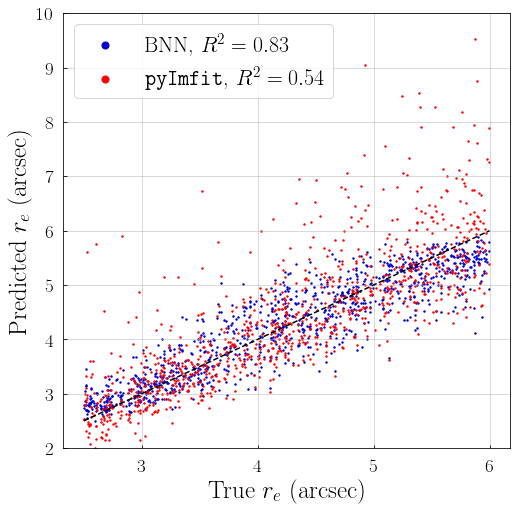

In [58]:
x = np.linspace(2.5,6.0,100)
plt.figure(figsize=(8., 8.))


plt.scatter(r_eff_true,r_eff_pred,s=2.0,c='mediumblue',label='BNN, $R^2 = 0.83$')
plt.scatter(r_eff_true,r_eff_imf,s=2.0,c='red', label=r'\texttt{pyImfit}, $R^2 = 0.54$')
plt.plot(x,x,ls='--',c='k')
plt.grid(alpha=0.6)

plt.xlabel('True $r_e$ (arcsec)', fontsize=25)
plt.ylabel('Predicted $r_e$ (arcsec)', fontsize=25)

plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc='upper left',ncol=1, fontsize=22,markerscale=5)

plt.ylim(2,10)
# Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/BNN_pyImfit_reff.pdf",bbox_inches='tight')
plt.show()

In [59]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(I_eff_true, I_eff_pred)

R_square_BNN = np.copy(r_value)**2.0

print(R_square_BNN)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(I_eff_true, I_eff_imf)

R_square_imf = np.copy(r_value)**2.0

print(R_square_imf)

0.8407373741963423
0.6986332521603296


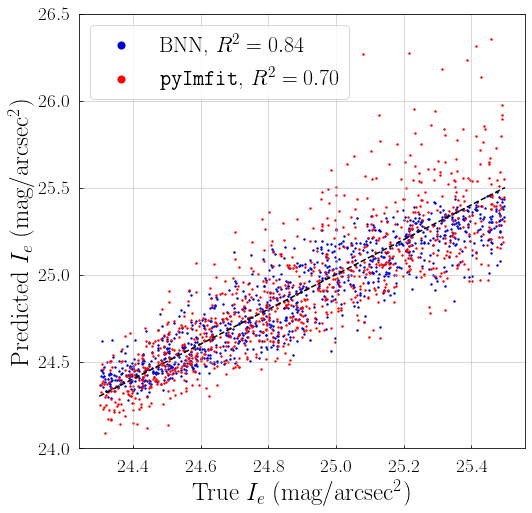

In [65]:
x = np.linspace(24.3,25.5,100)
plt.figure(figsize=(8., 8.))


plt.scatter(I_eff_true,I_eff_pred,s=2.0,c='mediumblue',label='BNN, $R^2 = 0.84$')
plt.scatter(I_eff_true,I_eff_imf,s=2.0,c='red', label=r'\texttt{pyImfit}, $R^2 = 0.70$')
plt.plot(x,x,ls='--',c='k')
plt.grid(alpha=0.6)

plt.xlabel('True $I_e$ (mag/arcsec$^2$)', fontsize=25)
plt.ylabel('Predicted $I_e$ (mag/arcsec$^2$)', fontsize=25)

plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc='upper left',ncol=1, fontsize=22,markerscale=5)

plt.ylim(24,26.5)
# Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/BNN_pyImfit_Ieff.pdf",bbox_inches='tight')
plt.show()

In [66]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(n_true, n_pred)

R_square_BNN = np.copy(r_value)**2.0

print(R_square_BNN)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(n_true, n_imf)

R_square_imf = np.copy(r_value)**2.0

print(R_square_imf)

0.8593773897411945
0.7044423927744214


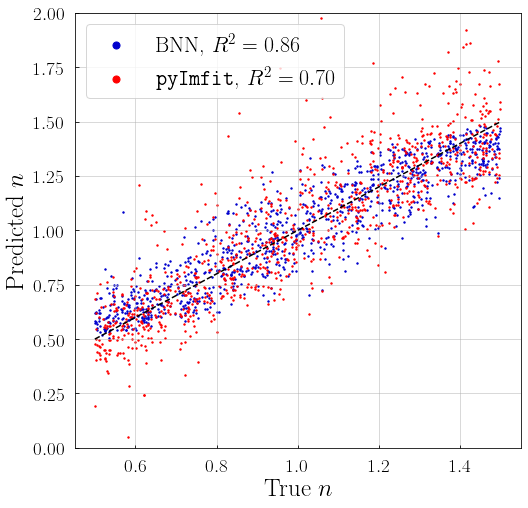

In [70]:
x = np.linspace(0.5,1.5,100)
plt.figure(figsize=(8., 8.))


plt.scatter(n_true,n_pred,s=2.0,c='mediumblue',label='BNN, $R^2 = 0.86$')
plt.scatter(n_true,n_imf,s=2.0,c='red', label=r'\texttt{pyImfit}, $R^2 = 0.70$')
plt.plot(x,x,ls='--',c='k')
plt.grid(alpha=0.6)

plt.xlabel('True $n$', fontsize=25)
plt.ylabel('Predicted $n$', fontsize=25)

plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc='upper left',ncol=1, fontsize=22,markerscale=5)

plt.ylim(0,2)
# Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/BNN_pyImfit_n.pdf",bbox_inches='tight')
plt.show()

In [71]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ell_true, ell_pred)

R_square_BNN = np.copy(r_value)**2.0

print(R_square_BNN)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ell_true, ell_imf)

R_square_imf = np.copy(r_value)**2.0

print(R_square_imf)

0.9396240898204263
0.9375282267792293


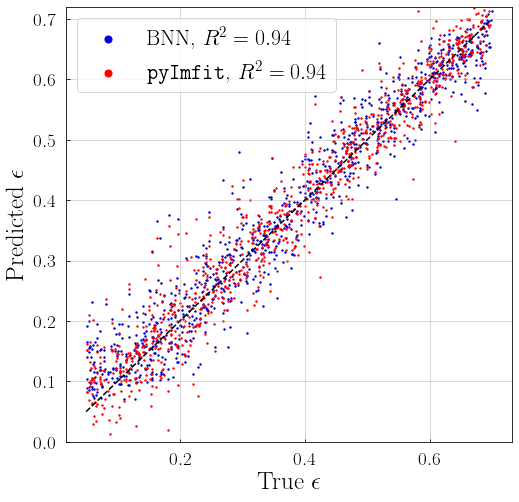

In [74]:
x = np.linspace(0.05,0.7,100)
plt.figure(figsize=(8., 8.))


plt.scatter(ell_true,ell_pred,s=2.0,c='mediumblue',label='BNN, $R^2 = 0.94$')
plt.scatter(ell_true,ell_imf,s=2.0,c='red', label=r'\texttt{pyImfit}, $R^2 = 0.94$')
plt.plot(x,x,ls='--',c='k')
plt.grid(alpha=0.6)

plt.xlabel('True $\epsilon$', fontsize=25)
plt.ylabel('Predicted $\epsilon$', fontsize=25)

plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc='upper left',ncol=1, fontsize=22,markerscale=5)

plt.ylim(0,0.72)
# Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/BNN_pyImfit_ell.pdf",bbox_inches='tight')
plt.show()

In [75]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(PA_true, PA_pred)

R_square_BNN = np.copy(r_value)**2.0

print(R_square_BNN)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(PA_true, PA_imf)

R_square_imf = np.copy(r_value)**2.0

print(R_square_imf)

0.732128409556933
0.7568183424389306


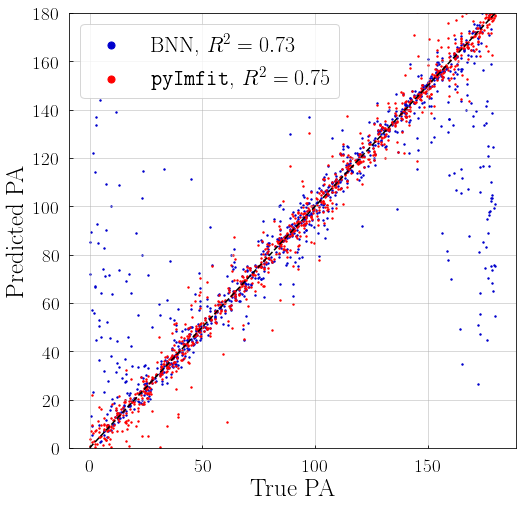

In [80]:
x = np.linspace(0,180,100)
plt.figure(figsize=(8., 8.))


plt.scatter(PA_true,PA_pred,s=2.0,c='mediumblue',label='BNN, $R^2 = 0.73$')
plt.scatter(PA_true,PA_imf,s=2.0,c='red', label=r'\texttt{pyImfit}, $R^2 = 0.75$')
plt.plot(x,x,ls='--',c='k')
plt.grid(alpha=0.6)

plt.xlabel('True PA', fontsize=25)
plt.ylabel('Predicted PA', fontsize=25)

plt.tick_params(axis='both', labelsize=19)
plt.legend(frameon=True, loc='upper left',ncol=1, fontsize=22,markerscale=5)

plt.ylim(0,180)
# Save
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/BNN_pyImfit_PA.pdf",bbox_inches='tight')
plt.show()